In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
from gym_stock_trading_env import StockTradingEnv
from functions.strategy import PercentChangeStrategy, ExtremaStrategy
from functions.strategy import PercentChangeStrategy, ExtremaStrategy
from functions.position_size import *
from functions.risk_management import *
from functions.reward_functions import *
from functions.transaction_cost import *
from functions.other_utils import *

In [9]:
def custom_render(env):
    clear_output(wait=True)
    
    current_price = float(env.df.loc[env.current_step, 'Close'])
    env.total_asset_value = env.balance + env.num_shares * current_price
    
    zoom_window = 30
    current = env.current_step
    
    if current < env.max_steps:
        start_idx = max(0, current - zoom_window)
        end_idx = current + 1
    else:
        start_idx = 0
        end_idx = len(env.df)
    
    x_data = range(start_idx, end_idx)
    y_data = env.df['Close'].iloc[start_idx:end_idx].values

    plt.figure(figsize=(12, 6))
    plt.plot(x_data, y_data, label='Close Price', color='blue', linewidth=2)
    
    plt.scatter(current, current_price, color='orange', marker='o', s=150, label='Current Price')
    
    buys = [t for t in env.trade_history if t['action'] == 'buy' and start_idx <= t['step'] < end_idx]
    sells = [t for t in env.trade_history if t['action'] == 'sell' and start_idx <= t['step'] < end_idx]
    
    if buys:
        buy_steps = [t['step'] for t in buys]
        buy_prices = [t['price'] for t in buys]
        plt.scatter(buy_steps, buy_prices, color='green', marker='^', s=120, label='Buy')
        for bs, bp, trade in zip(buy_steps, buy_prices, buys):
            annotation = f"{bp:.2f} ({trade['quantity']})"
            plt.annotate(annotation, (bs, bp), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    
    if sells:
        sell_steps = [t['step'] for t in sells]
        sell_prices = [t['price'] for t in sells]
        plt.scatter(sell_steps, sell_prices, color='red', marker='v', s=120, label='Sell')
        for ss, sp, trade in zip(sell_steps, sell_prices, sells):
            annotation = f"{sp:.2f} ({trade['quantity']})"
            plt.annotate(annotation, (ss, sp), textcoords="offset points", xytext=(0, -10), ha='center', color='red')
    
    title = f"Step: {env.current_step} | Balance: {env.balance:.2f} | Shares: {env.num_shares} | Total Asset: {env.total_asset_value:.2f}"
    plt.title(title, fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    time.sleep(0.1)


In [10]:

df = yf.download("AAPL", start="2022-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed


In [11]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.879898,179.734947,174.653859,174.771790,104487900
2022-01-04,176.609650,179.793936,176.039622,179.489269,99310400
2022-01-05,171.911835,177.071549,171.636651,176.521181,94537600
2022-01-06,169.042068,172.285320,168.688259,169.730027,96904000
2022-01-07,169.209137,171.145259,168.088742,169.916756,86709100
...,...,...,...,...,...
2022-12-23,130.344498,130.898059,128.150012,129.415299,63814900
2022-12-27,128.535538,129.899682,127.240596,129.870028,69007800


In [12]:

env = StockTradingEnv(df, initial_balance=10000, transaction_cost_pct=0.001, custom_render=custom_render)

c:\Users\mikol\OneDrive\Pulpit\Projekty_prywatne\Stock-trading-Reinforcement-Learning\gym_stock_trading_env.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.df.loc[self.current_step, 'Close'])


In [13]:
# Choose a strategy.
strategy = ExtremaStrategy(window=3)

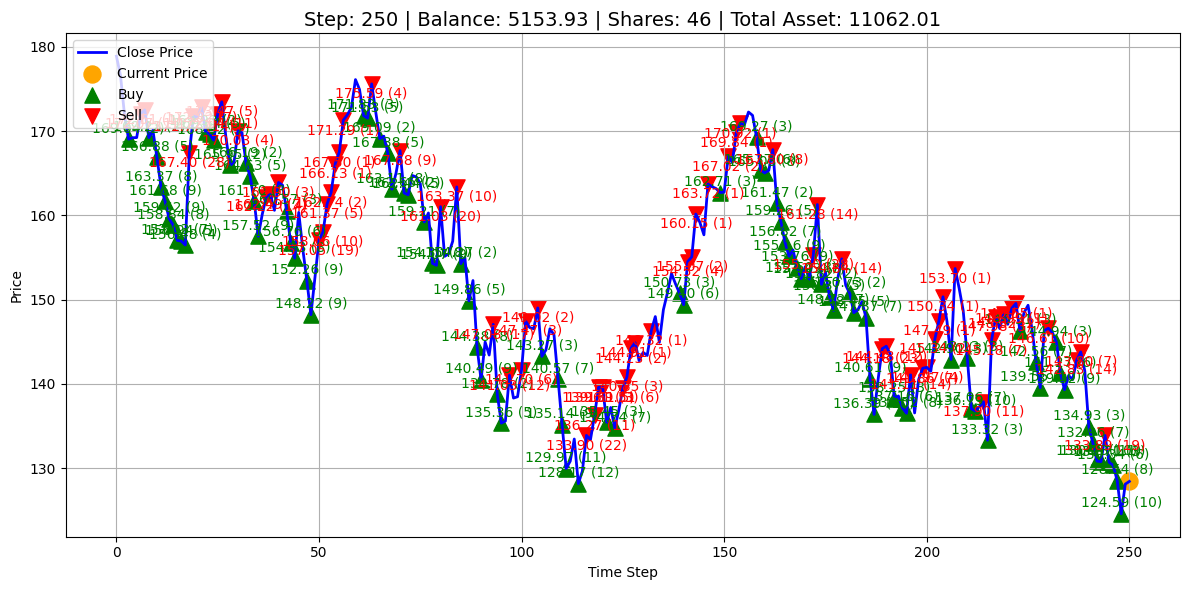

In [14]:
# Reset the environment.
obs = env.reset()
done = False
step = 0

while not done:
    # Transform the state.
    state = state_transformation(obs)
    
    # Get the action from the chosen strategy.
    action = strategy.get_action(env)
    
    # Determine position sizing.
    quantity = scale_in_position_sizing(state, env, action, base_fraction=0.05)
    
    # Risk management.
    action, quantity = max_loss_risk_management(state, env, action, quantity)
    
    # Transaction cost adjustments.
    quantity = transaction_cost_function(state, env, action, quantity)
    
    # Execute the step.
    obs, raw_reward, done, info = env.step((action, quantity))
    
    # Compute final reward.
    final_reward = reward_function(state, env, raw_reward, info)
    
    # Logging.
    logging_callback(step, state, action, quantity, final_reward, info)
    
    # Render the updated plot.
    env.render()
    
    step += 1